# 06 Sales Prediction Model

This notebook trains and evaluates machine learning models for sales prediction using Spark MLlib.

## Import Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.regression import (
    LinearRegression, 
    DecisionTreeRegressor,
    RandomForestRegressor,
    GBTRegressor
)
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import pandas as pd

## Initialize Spark Session

In [2]:
spark = SparkSession.builder \
    .appName("SalesPredictionModel") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print("Spark session initialized successfully!")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/06 11:38:06 WARN Utils: Your hostname, pc-ThinkPad-P15-Gen-1, resolves to a loopback address: 127.0.1.1; using 10.42.101.241 instead (on interface wlp0s20f3)
26/01/06 11:38:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/06 11:38:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark session initialized successfully!


## Load Feature-Engineered Data

In [3]:
try:
    df = spark.read.parquet("processed/sales_new_features.parquet")
    print("Loaded feature-engineered data successfully!")
    print(f"Total rows: {df.count():,}")
except Exception as e:
    print(f"Error loading features: {e}")
    print("Please run 05_feature_engineering.ipynb first!")
    raise

Loaded feature-engineered data successfully!
Total rows: 128,975


## Prepare Data for Training

In [4]:
df = df.filter(
    col("amount").isNotNull() & 
    (col("amount") > 0) &
    col("features").isNotNull()
)

print(f"Filtered dataset: {df.count():,} rows")

Filtered dataset: 118,837 rows


## Split Train/Test Data

In [5]:
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

print(f"Training set: {train_data.count():,} rows")
print(f"Test set: {test_data.count():,} rows")

26/01/06 11:38:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Training set: 83,324 rows


Test set: 35,513 rows


## Model 1: Linear Regression (Baseline)

In [6]:
lr = LinearRegression(
    featuresCol="features",
    labelCol="amount",
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.5
)

lr_model = lr.fit(train_data)
print("Linear Regression model trained!")

Linear Regression model trained!


### Linear Regression Evaluation

In [7]:
lr_predictions = lr_model.transform(test_data)

evaluator = RegressionEvaluator(
    labelCol="amount",
    predictionCol="prediction",
    metricName="rmse"
)

lr_rmse = evaluator.evaluate(lr_predictions)
lr_r2 = evaluator.setMetricName("r2").evaluate(lr_predictions)
lr_mae = evaluator.setMetricName("mae").evaluate(lr_predictions)

print("Linear Regression Results:")
print(f"  RMSE: {lr_rmse:.2f}")
print(f"  R²: {lr_r2:.4f}")
print(f"  MAE: {lr_mae:.2f}")

Linear Regression Results:
  RMSE: 253.05
  R²: 0.1066
  MAE: 204.17


## Predictions Visualization

In [8]:
lr_predictions.select("amount", "prediction").toPandas().head()

,amount,prediction
0,647.62,639.764224
1,824.00,722.290682
2,653.00,747.358122
3,399.00,666.399293
4,544.00,694.615372


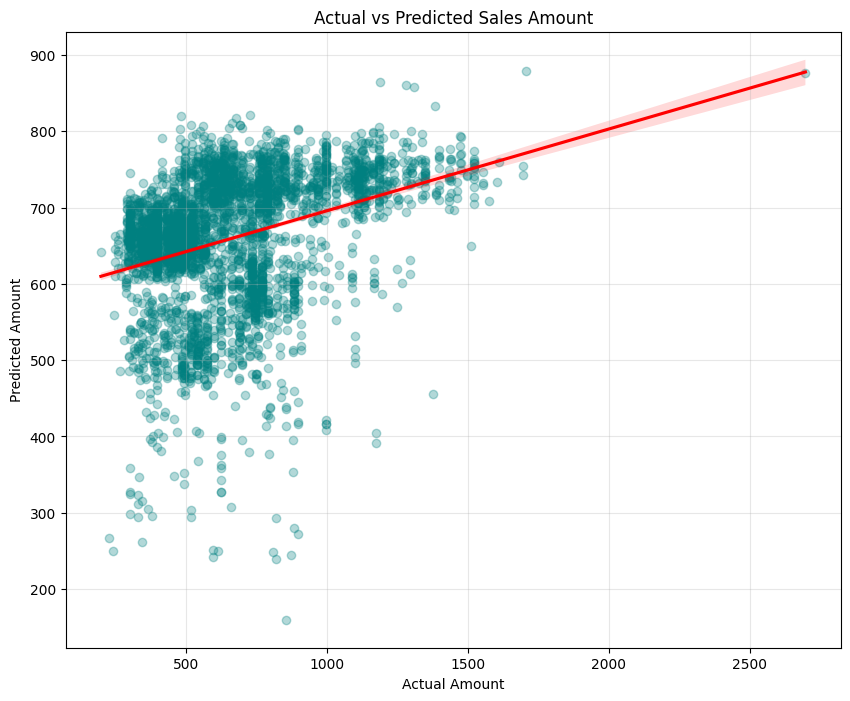

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


results_pd = lr_predictions.select("amount", "prediction").sample(False, 0.1).toPandas()
plt.figure(figsize=(10, 8))
sns.regplot(x="amount", y="prediction", data=results_pd, 
            scatter_kws={'alpha':0.3, 'color':'teal'}, 
            line_kws={'color':'red', 'label':'Perfect Prediction'})
plt.title('Actual vs Predicted Sales Amount')
plt.xlabel('Actual Amount')
plt.ylabel('Predicted Amount')
plt.grid(True, alpha=0.3)
plt.show()

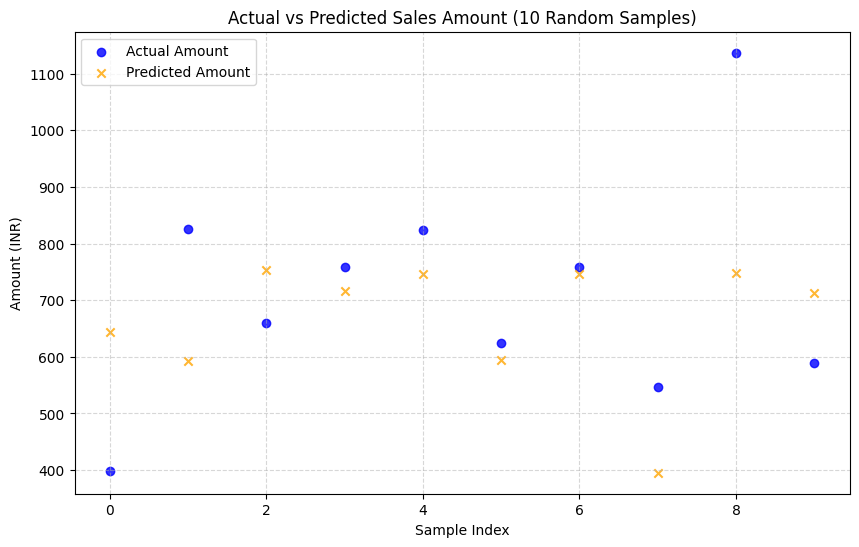

In [10]:
from pyspark.sql.functions import rand
import matplotlib.pyplot as plt

# Select 10 random samples
sample_df = lr_predictions.select("amount", "prediction").orderBy(rand()).limit(10).toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(sample_df.index, sample_df['amount'], label='Actual Amount', alpha=0.8, color='blue')
plt.scatter(sample_df.index, sample_df['prediction'], label='Predicted Amount', alpha=0.8, color='orange', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Amount (INR)')
plt.title('Actual vs Predicted Sales Amount (10 Random Samples)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Clean Up

In [12]:
spark.stop()
print("Spark session stopped!")

Spark session stopped!
